In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px
import torch
from collections import namedtuple
import cv2
import torchvision.transforms as transforms
import torch.nn.functional as F
import seaborn as sns

In [2]:
import os, sys
sys.path.append('.')

from dynamics_models import *
from kf_measurement_models import *
from pf_measurement_models import *
from virtual_sensor_models import *
from utils import *
from coordinates import *
from structs import *
from flow_geometry import *
from monodepth2.networks.monodepth2 import Monodepth2DepthNet

%load_ext autoreload
%autoreload 2

In [3]:
config = Config(6, [100, 100], 3)
# K = torch.tensor([
#     [552.554261, 0.000000, 682.049453, 0], 
#     [0.000000, 552.554261, 238.769549, 0], 
#     [0.000000, 0.000000, 1.000000, 0],
#     [0.000000, 0.000000, 0.000000, 1]
#     ])

K = torch.tensor([
    [1086.160899, 0.000000, 940.067502, 0], 
    [0.000000, 1090.242963, 586.740077, 0], 
    [0.000000, 0.000000, 1.000000, 0],
    [0.000000, 0.000000, 0.000000, 1]
    ])

H_b2c = torch.tensor([ 
    [9.9934608718980233e-01, -1.5715484428488590e-02,-3.2564114721728155e-02, -1.7434527332030676e-02],
    [3.2359037356803094e-02, -1.3131917124154624e-02,9.9939003669937865e-01, 1.7171139776467173e-01],
    [-1.6133527815482926e-02, -9.9979026615676858e-01,-1.2614792047622947e-02, -4.5251036141047592e-02], 
    [0, 0, 0, 1]], dtype=torch.float32)
                      
camera_config = CameraConfig(K, H_b2c)
dynamics_model = CarPoseDynamicsModel()

In [4]:
# path_manager = PathManager('/oak/stanford/groups/gracegao/KITTI360/KITTI-360/data_2d_raw', '2013_05_28_drive_0000_sync') 
path_manager = HKPathManager('/oak/stanford/groups/gracegao/HKdataset/Data', '/oak/stanford/groups/gracegao/HKdataset/UrbanNav_TST_GT_raw.csv')

In [5]:
tmp_gt = path_manager.gt.loc[0]
lcoord = LocalCoord.from_geodetic(read_lla(tmp_gt))

In [39]:
pos_l = {
    'x': [],
    'y': [],
    'z': []
}

for i in range(len(path_manager.gt)):
    tmp_gt = path_manager.gt.loc[i]
    
    H_cam_world = gt_to_pose(tmp_gt, camera_config.T_b_c, lcoord)
    pos_l['x'].append(H_cam_world[0,3])
    pos_l['y'].append(H_cam_world[1,3])
    pos_l['z'].append(H_cam_world[2,3])
    
#     ecef = gt_to_ned(tmp_gt, lcoord)
#     pos_l['x'].append(ecef[0])
#     pos_l['y'].append(ecef[1])
#     pos_l['z'].append(ecef[2])

In [40]:
H_cam1_world = gt_to_pose(path_manager.gt.loc[45], camera_config.T_b_c, lcoord)
H_cam2_world = gt_to_pose(path_manager.gt.loc[46], camera_config.T_b_c, lcoord)
torch.linalg.inv(H_cam2_world) @ H_cam1_world

tensor([[ 1.0000e+00, -1.1966e-05, -3.4153e-05,  3.0518e-05],
        [ 1.1960e-05,  1.0000e+00, -8.0060e-05, -1.0026e-03],
        [ 3.4213e-05,  8.0062e-05,  1.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])

(-500.0, 250.0)

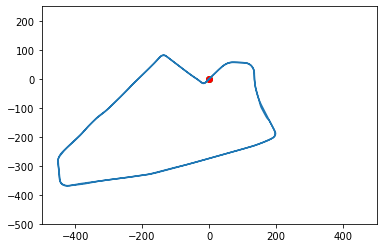

In [41]:
pos_l = {key: np.array(pos_l[key]) for key in pos_l.keys()}
fig = plt.figure()
# ax = plt.axes(projection='3d')
ax = plt.axes()
ax.plot(pos_l['x'], pos_l['y'])
plt.scatter([pos_l['x'][0]], [pos_l['y'][0]], color='g')
plt.scatter([pos_l['x'][-1]], [pos_l['y'][-1]], color='r')
ax.set_xlim((-500, 500))
ax.set_ylim((-500, 250))


# fig = plt.figure()
# ax = plt.axes()
# pts = torch.zeros(4, 20)
# pts[3, :] = 1.0
# pts[2, :5] = torch.arange(5)*10
# pts[2, 5:] = pts[2, 4]
# pts[0, 5:15] = torch.arange(10)*(-20)
# pts[0, 15:] = pts[0, 14]
# pts[2, 15:] += torch.arange(5)*10

# pts = H_cam_world @ pts
# plt.plot(pts[0, :], pts[1, :])
# plt.scatter([pts[0, 0]], [pts[1, 0]])
# plt.scatter([pts[0, -1]], [pts[1, -1]], color='r')
# ax.set_xlim((-500, 500))
# ax.set_ylim((-500, 250))

# dir_vec = np.array((np.gradient(pos_l['x'])[0], np.gradient(pos_l['y'])[0], np.gradient(pos_l['z'])[0]))
# dir_vec /= np.linalg.norm(dir_vec)
# dir_vec

In [138]:
img1 = cv2.imread(path_manager.get_path(0))  # 228, 238
img2 = cv2.imread(path_manager.get_path(1))  # 260 is where motion starts

# img1 = cv2.resize(img1, (768, 192)) 
# img2 = cv2.resize(img2, (768, 192)) 

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)


flow = cv2.calcOpticalFlowFarneback(img1_gray, img2_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
flow = torch.tensor(flow).cuda()
H, W, _ = flow.shape

In [ ]:
# test_im_id = 1556456306922991401
# for i, impath in enumerate(path_manager.image_paths):
#     if str(test_im_id)+'.png'==impath.split('/')[-1]:
#         print(i)

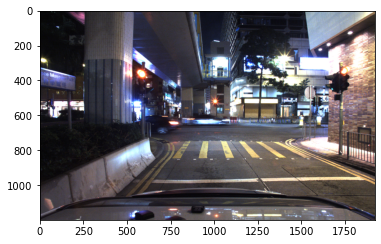

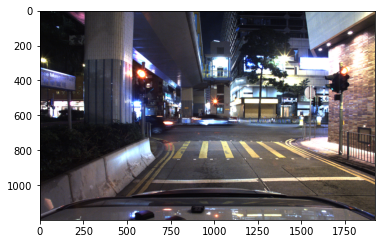

In [140]:
plt.imshow(img1)
plt.figure()
plt.imshow(img2)

In [ ]:
print("Measured optical flow, (u v)")
plt.imshow(flow.cpu()[:, :, 0], vmin=0, vmax=10)
plt.figure()
plt.imshow(flow.cpu()[:, :, 1], vmin=0, vmax=10)

In [ ]:
depth_net = Monodepth2DepthNet(H, W)
depth_net.initialize_network_model(
                    weight_path="/oak/stanford/groups/gracegao/depth_pretrained_weights",
                    dataset='kitti',
                    finetune=False)
transform_totensor = transforms.ToTensor()
# depth_size = (shift_bit_length(img1.shape[0]), shift_bit_length(img1.shape[1]))
depth_size = (768, 192)
transform_resize_in = transforms.Resize(size=depth_size)
transform_resize_out = transforms.Resize(size=(img1.shape[0], img1.shape[1]))

def resized_in_out(depth_net, image_in):
    img = cv2.resize(image_in, depth_size)
    img = transform_totensor(img)
    depth = depth_net.inference_depth(img.expand((1,3,depth_size[1], depth_size[0])).cuda())
    return transform_resize_out(depth)

depth_net.stereo_baseline_multiplier = 1.0
og_depth = resized_in_out(depth_net, img1)

In [ ]:
print("Depth")
plt.imshow(og_depth.cpu()[0, 0, :, :])

In [ ]:
plt.hist(og_depth.cpu().detach().numpy().reshape(-1))

In [ ]:
depth_backproj = Backprojection(H, W)
camera_proj = Projection(H, W)
rigid_flow = RigidFlow(H, W).cuda()

In [ ]:
K = camera_config.K.unsqueeze(0).cuda()
inv_K = torch.linalg.inv(camera_config.K).unsqueeze(0).cuda()

In [ ]:
# plt.imshow(flow[:, :, 0])
# plt.figure()
# plt.imshow(flow[:, :, 1])

# pts = torch.ones((3, H*W))
# pts[:2, :] = torch.cartesian_prod(torch.arange(H), torch.arange(W)).T
# pts_3d = torch.mul(depth.reshape((1, H*W)), torch.linalg.inv(camera_config.K) @ pts)
# pts_3d = depth_backproj(depth, torch.linalg.inv(camera_config.K).expand((1, 3, 3)))

In [ ]:
R_cam1 = torch.tensor(eul2rot([np.deg2rad(-1.2798992), np.deg2rad(0.30598), np.deg2rad(228.0393)]), dtype=torch.float32)
R_cam2 = torch.tensor(eul2rot([np.deg2rad(-1.27691), np.deg2rad(0.304097), np.deg2rad(228.0407)]), dtype=torch.float32)
T_cam1 = torch.tensor([*lla_to_ecef(22.301154486, 114.179000474, 6.463121893)], dtype=torch.float32)
T_cam2 = torch.tensor([*lla_to_ecef(22.301154462, 114.179000483, 6.460401025)], dtype=torch.float32)
H_body_cam = camera_config.T_b_c.cuda()
H_cam1 = H_body_cam @ torch.linalg.inv(vars_to_H(T_cam1, R_cam1))
H_cam2 = H_body_cam @ torch.linalg.inv(vars_to_H(T_cam2, R_cam2))
H_cam2 @ torch.linalg.inv(H_cam1)

In [ ]:
T_cam1, T_cam2

In [ ]:
# trans_vars = torch.tensor([-3.7500e+00, 3.0000e+00, 7.0000e+00], requires_grad=True)
trans_vars = torch.tensor([0.0, 0.0, 5.0], requires_grad=True)
v1_vars = torch.tensor([1., -1.9968e-06, 4.3231e-05]) #+ 0.01*torch.randn(3)
v2_vars = torch.tensor([1.9968e-06, 1., -9.7519e-06]) #+ 0.01*torch.randn(3)
v1_vars.requires_grad = True
v2_vars.requires_grad = True
optimizer = torch.optim.SGD([trans_vars, v1_vars, v2_vars], lr=0.01, momentum=0.9)

In [ ]:
H_vo = torch.linalg.inv(vars_to_H(trans_vars, (v1_vars, v2_vars)))
H_vo

In [ ]:
# optimizer.zero_grad()
quiver_step = 20
fig = plt.figure(figsize=(20, 12), dpi=80)
errors = []
depth_list = [i+1 for i in range(0, 1200, 100)]
for i, d in enumerate(depth_list):
    depth = og_depth.clone()*d
    
    rflow = rigid_flow(depth, H_vo.unsqueeze(0), K, inv_K, normalized=False)
#     reproj_xy = rigid_flow.reprojection(depth, H_vo.unsqueeze(0), K, inv_K, normalized=False)
    
    ax = fig.add_subplot(3*int(len(depth_list)/6) + 2, 6,i+1)
    ax.imshow(torch.abs(rflow.cpu().detach())[0, 0, :, :], vmin=0, vmax=100)
    ax.set_title("u, Depth={d}".format(d=d))
    
    ax = fig.add_subplot(3*int(len(depth_list)/6) + 2, 6,i+1+len(depth_list))
    ax.set_title("v, Depth={d}".format(d=d))
    ax.imshow(torch.abs(rflow.cpu().detach())[0, 1, :, :], vmin=0, vmax=100)
    
    rflow = rflow.cpu().detach()
    ax = fig.add_subplot(3*int(len(depth_list)/6) + 2, 6,i+1+2*len(depth_list))
    ax.set_title("flow, Depth={d}".format(d=d))
    ax.quiver(rflow[0, 0, ::quiver_step, ::quiver_step], rflow[0, 1, ::quiver_step, ::quiver_step])
#     ax = fig.add_subplot(2*int(len(depth_list)/6) + 2, 6,i+1)
#     ax.set_title("x, Depth={d}".format(d=d))
#     ax.imshow(reproj_xy.cpu().detach()[0, :, :, 0])
    
#     ax = fig.add_subplot(2*int(len(depth_list)/6) + 2, 6,i+1+len(depth_list))
#     ax.set_title("y, Depth={d}".format(d=d))
#     ax.imshow(reproj_xy.cpu().detach()[0, :, :, 1])
    
#     errors.append(torch.mean(torch.abs(rflow[0, 0, :, :] - flow[:, :, 0])).cpu().detach() + torch.mean(torch.abs(rflow[0, 1, :, :] - flow[:, :, 1])).cpu().detach())
# reproj_xy = rigid_flow.reprojection(depth, H_vo.unsqueeze(0), K, inv_K, normalized=False)
# points3d = rigid_flow.reprojection.backproj(depth, inv_K)
# loss = torch.mean(torch.square(rflow[0, 0, :, :] - flow[:, :, 0])) + torch.mean(torch.square(rflow[0, 1, :, :] - flow[:, :, 1]))
# loss.backward()
# optimizer.step()

In [ ]:
rflow

In [ ]:
plt.plot(depth_list, errors)
# plt.ylim((0, 1e3))

In [ ]:
plt.imshow(rflow.cpu().detach()[0, 0, :, :] - flow.cpu()[:, :, 0])
plt.figure()
plt.imshow(rflow.cpu().detach()[0, 1, :, :] - flow.cpu()[:, :, 1])

In [ ]:
# plt.imshow(reproj_xy.cpu().detach().numpy()[0, :, :, 0])
# plt.figure()
# plt.imshow(reproj_xy.cpu().detach().numpy()[0, :, :, 1])

In [ ]:
def generate_data(config, camera_config, sparse_map):
    T = 20
    times = torch.arange(T)
    states = torch.zeros(T, 6)
    poses = [None]*T
    poses[0] = Isometry3d(torch.eye(3), torch.zeros(3))
    flow = [torch.zeros(config.observation_dim, config.observation_dim)]*T
    controls = torch.stack([torch.sin((2*np.pi/T)*times*k) for k in range(config.control_dim)]).T
    
    
    
    for t in range(1, T):
        next_state, Q = dynamics_model(states[t-1, :][None, :], controls[t, :][None, :])
        states[t, :] = next_state.squeeze(0) + batched_mm(Q, torch.randn((1, config.state_dim))).squeeze(0)
        car_pose = CarPose(states[t, :].detach().numpy()...)
        T_t = torch.Tensor([car_pose.x, car_pose.y, 0])
        R_t = torch.Tensor(eul2rot(car_pose.theta, 0, 0))
        H_t = Isometry3d(R_t, T_t)
        poses[t] = H_t
        rel_pose = poses[t-1].relative(H_t)
        
        
    return Data(observations, controls, states, satellite_states, N_observations) 

data = generate_data(config)